# CIS545 Group Project

By Liancheng Gong, Yuxuan Hu, Jinyun Shan <br>
December 2022

# Overview

There are several motivations for detecting insurance fraud. One of the main reasons is to prevent individuals and organizations from taking advantage of the insurance system and making fraudulent claims. This helps to keep insurance costs under control and ensures that premiums remain affordable for legitimate policyholders. Additionally, detecting and preventing insurance fraud can help to protect the reputation of the insurance company and maintain trust with its customers. Insurance fraud can also have negative effects on the economy, as it can lead to higher prices for goods and services that are insured. By detecting and preventing fraud, insurance companies can help to ensure that the insurance system is fair and sustainable for everyone.

In this project, we utilized data of automobile accidents and whether they are insurance frauds, trying to create a predictive model based on these data. We intend to study and analyze the data of insurance claims of automobiles, policy details, vehicle details, claim details and also the customer demographic information, etc. 

In this notebook, we classify whether the insurance is fraud or not via data preprocessing and modeling. We use scikit learning packages, including Logistic Regression, Decision Tree Classification, Random Forest Classification, AdaBoost Classification, and Neural Network, to fit the data. By constructing models and comparing the performances of different models, we select one main model with the highest accuracy score as our final model. In this case, we chose Random Forest as our final model for the data. 

# Imports

In [ ]:
# Imports and Setups
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

# Data Loading and Preprocessiong

Link to CSVs: (NEED TO LOAD TO RUN NOTEBOOK)  
https://drive.google.com/drive/folders/1GgqybnmCDSFkl7aAU6zuaqoACqzDYcVK?usp=sharing

We have in total five CSVs, including claim, demographics, policy, vehicle, and dataTarget. In this section, we merges those datasets and get to know about the detailed columns and distributions of values. 

First, let's load 5 csv files.

In [ ]:
# display all columns
pd.set_option('display.max_columns', None) 

In [ ]:
# Load 5 csv files
claim = pd.read_csv('Claim.csv')
demographics= pd.read_csv('Demographics.csv')
policy = pd.read_csv('Policy.csv')
vehicle = pd.read_csv('Vehicle.csv')
dataTarget = pd.read_csv('data_with_Target.csv')

In [ ]:
# shape of all files
(claim.shape),(demographics.shape),(policy.shape),(vehicle.shape),(dataTarget.shape)

((28836, 19), (28836, 10), (28836, 10), (115344, 3), (28836, 2))

#### Combine dataframes

Noticing that vehicle has four rows (VehicleID, VehicleModel, VehicleMake, VehicleYOM) for one Customer, we reconstruct the dataframe into one row for each customerID.

In [ ]:
vehicle.head()

,CustomerID,VehicleAttribute,VehicleAttributeDetails
0,Cust20179,VehicleID,Vehicle8898
1,Cust21384,VehicleModel,Malibu
2,Cust33335,VehicleMake,Toyota
3,Cust27118,VehicleModel,Neon
4,Cust13038,VehicleID,Vehicle30212


In [ ]:
vehicle['VehicleAttribute'].value_counts()

VehicleID       28836
VehicleModel    28836
VehicleMake     28836
VehicleYOM      28836
Name: VehicleAttribute, dtype: int64

In [ ]:
# Rename Columns
vehicleid = vehicle[vehicle['VehicleAttribute']=='VehicleID'][['CustomerID','VehicleAttributeDetails']].rename(columns={'VehicleAttributeDetails':'VehicleID'})
vehiclemodel = vehicle[vehicle['VehicleAttribute']=='VehicleModel'][['CustomerID','VehicleAttributeDetails']].rename(columns={'VehicleAttributeDetails':'VehicleModel'})
vehiclemake = vehicle[vehicle['VehicleAttribute']=='VehicleMake'][['CustomerID','VehicleAttributeDetails']].rename(columns={'VehicleAttributeDetails':'VehicleMake'})
vehicleyom = vehicle[vehicle['VehicleAttribute']=='VehicleYOM'][['CustomerID','VehicleAttributeDetails']].rename(columns={'VehicleAttributeDetails':'VehicleYOM'})

In [ ]:
# Merge all our dataframes based on Customer ID
df1 = pd.merge(dataTarget,claim, on = ['CustomerID'], how='inner')
df2 = pd.merge(df1,demographics,on = ['CustomerID'], how='inner')
df3 = pd.merge(df2,policy,on = ['CustomerID'], how='inner')
df4 = pd.merge(df3,vehicleid,on = ['CustomerID'], how='inner')
df5 = pd.merge(df4,vehiclemodel,on = ['CustomerID'], how='inner')
df6 = pd.merge(df5,vehiclemake,on = ['CustomerID'], how='inner')
df = pd.merge(df6,vehicleyom,on = ['CustomerID'], how='inner')

In [ ]:
df.head()

,CustomerID,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleModel,VehicleMake,VehicleYOM
0,Cust20065,N,2015-01-09,Multi-vehicle Collision,Rear Collision,Total Loss,Other,State9,City4,Location 1404,19,3,?,1,1,?,43973,9396,4698,29879,58,471784,MALE,JD,sales,video-games,0,-42700,India,129186,432,1998-11-14,State2,250/500,2000,1142.87,0,own-child,Vehicle30662,E400,Mercedes,2005
1,Cust37589,N,2015-02-20,Single Vehicle Collision,Side Collision,Minor Damage,Ambulance,State4,City3,Location 1675,14,1,?,1,1,YES,62310,6539,6539,49232,34,431937,FEMALE,High School,transport-moving,polo,51300,0,India,146710,128,2000-08-19,State2,100/300,1000,1274.38,2857344,own-child,Vehicle17183,Highlander,Toyota,2010
2,Cust24312,N,2015-01-14,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State5,City2,Location 1546,21,3,?,0,0,?,42824,6069,6069,30686,52,479320,FEMALE,PhD,machine-op-inspct,exercise,0,0,India,133433,346,2000-06-23,State1,500/1000,745,1269.93,0,other-relative,Vehicle33982,Passat,Volkswagen,2002
3,Cust5493,Y,2015-01-07,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State7,City4,Location 1413,12,3,YES,2,0,?,45672,253,5741,39678,25,607763,FEMALE,College,exec-managerial,exercise,47400,-56100,India,114614,42,1992-01-15,State2,100/300,986,1218.60,0,other-relative,Vehicle12299,Highlander,Toyota,2011
4,Cust7704,Y,2015-02-26,Multi-vehicle Collision,Side Collision,Major Damage,Other,State4,City6,Location 1367,3,3,NO,1,2,NO,81472,7407,14813,59252,27,441783,MALE,Masters,sales,chess,0,0,India,116825,109,2001-09-23,State3,250/500,576,1431.02,4235779,unmarried,Vehicle30447,Wrangler,Ford,2010


#### Check basic information

In [ ]:
df.shape

(28836, 42)

In [ ]:
df.describe()

,IncidentTime,NumberOfVehicles,BodilyInjuries,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,CapitalGains,CapitalLoss,InsurancePolicyNumber,CustomerLoyaltyPeriod,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit
count,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,2.883600e+04
mean,11.746047,1.823207,0.985782,7337.118428,7283.870197,37687.129387,38.815370,502436.579068,23066.569566,-24940.612429,129312.517097,203.067867,1114.282529,1255.528382,9.836680e+05
std,6.170069,0.980099,0.784764,4427.638593,4375.842738,17977.048232,7.996377,72250.868871,27637.813724,27913.209608,11114.060267,99.932951,546.632816,223.013899,1.969282e+06
min,-5.000000,1.000000,0.000000,0.000000,0.000000,109.000000,19.000000,430104.000000,0.000000,-111100.000000,110122.000000,1.000000,500.000000,-1.000000,-1.000000e+06
25%,6.000000,1.000000,0.000000,4743.750000,4862.000000,32193.250000,33.000000,448603.000000,0.000000,-50000.000000,119698.750000,126.000000,622.000000,1122.007500,0.000000e+00
50%,12.000000,1.000000,1.000000,7147.000000,7051.000000,42457.500000,38.000000,466691.000000,0.000000,0.000000,129278.500000,199.000000,1000.000000,1265.205000,0.000000e+00
75%,17.000000,3.000000,2.000000,10571.250000,10327.000000,49535.750000,44.000000,603848.000000,49000.000000,0.000000,138933.250000,267.000000,1627.000000,1396.605000,4.859610e+05
max,23.000000,4.000000,2.000000,21450.000000,23670.000000,79560.000000,64.000000,620962.000000,100500.000000,0.000000,148619.000000,479.000000,2000.000000,2047.590000,1.000000e+07


In [ ]:
df.nunique()

CustomerID                    28836
ReportedFraud                     2
DateOfIncident                   72
TypeOfIncident                    4
TypeOfCollission                  4
SeverityOfIncident                4
AuthoritiesContacted              5
IncidentState                     7
IncidentCity                      7
IncidentAddress                1000
IncidentTime                     25
NumberOfVehicles                  4
PropertyDamage                    3
BodilyInjuries                    3
Witnesses                         5
PoliceReport                      3
AmountOfTotalClaim            21976
AmountOfInjuryClaim           11958
AmountOfPropertyClaim         11785
AmountOfVehicleDamage         20041
InsuredAge                       46
InsuredZipCode                  995
InsuredGender                     2
InsuredEducationLevel             7
InsuredOccupation                14
InsuredHobbies                   20
CapitalGains                    338
CapitalLoss                 

In [ ]:
df.dtypes

CustomerID                     object
ReportedFraud                  object
DateOfIncident                 object
TypeOfIncident                 object
TypeOfCollission               object
SeverityOfIncident             object
AuthoritiesContacted           object
IncidentState                  object
IncidentCity                   object
IncidentAddress                object
IncidentTime                    int64
NumberOfVehicles                int64
PropertyDamage                 object
BodilyInjuries                  int64
Witnesses                      object
PoliceReport                   object
AmountOfTotalClaim             object
AmountOfInjuryClaim             int64
AmountOfPropertyClaim           int64
AmountOfVehicleDamage           int64
InsuredAge                      int64
InsuredZipCode                  int64
InsuredGender                  object
InsuredEducationLevel          object
InsuredOccupation              object
InsuredHobbies                 object
CapitalGains

In [ ]:
# null counts
df.isna().sum().sort_values(ascending=False)

InsuredGender                 30
Country                        2
DateOfPolicyCoverage           0
InsuredEducationLevel          0
InsuredOccupation              0
InsuredHobbies                 0
CapitalGains                   0
CapitalLoss                    0
InsurancePolicyNumber          0
CustomerLoyaltyPeriod          0
CustomerID                     0
ReportedFraud                  0
Policy_CombinedSingleLimit     0
Policy_Deductible              0
PolicyAnnualPremium            0
UmbrellaLimit                  0
InsuredRelationship            0
VehicleID                      0
VehicleModel                   0
VehicleMake                    0
InsurancePolicyState           0
InsuredZipCode                 0
InsuredAge                     0
AmountOfVehicleDamage          0
DateOfIncident                 0
TypeOfIncident                 0
TypeOfCollission               0
SeverityOfIncident             0
AuthoritiesContacted           0
IncidentState                  0
IncidentCi

#### Drop columns

Then we want to drop columns with bad quality or very loose correlation with the target.

In [ ]:
df.head()

,CustomerID,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleModel,VehicleMake,VehicleYOM
0,Cust20065,N,2015-01-09,Multi-vehicle Collision,Rear Collision,Total Loss,Other,State9,City4,Location 1404,19,3,?,1,1,?,43973,9396,4698,29879,58,471784,MALE,JD,sales,video-games,0,-42700,India,129186,432,1998-11-14,State2,250/500,2000,1142.87,0,own-child,Vehicle30662,E400,Mercedes,2005
1,Cust37589,N,2015-02-20,Single Vehicle Collision,Side Collision,Minor Damage,Ambulance,State4,City3,Location 1675,14,1,?,1,1,YES,62310,6539,6539,49232,34,431937,FEMALE,High School,transport-moving,polo,51300,0,India,146710,128,2000-08-19,State2,100/300,1000,1274.38,2857344,own-child,Vehicle17183,Highlander,Toyota,2010
2,Cust24312,N,2015-01-14,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State5,City2,Location 1546,21,3,?,0,0,?,42824,6069,6069,30686,52,479320,FEMALE,PhD,machine-op-inspct,exercise,0,0,India,133433,346,2000-06-23,State1,500/1000,745,1269.93,0,other-relative,Vehicle33982,Passat,Volkswagen,2002
3,Cust5493,Y,2015-01-07,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State7,City4,Location 1413,12,3,YES,2,0,?,45672,253,5741,39678,25,607763,FEMALE,College,exec-managerial,exercise,47400,-56100,India,114614,42,1992-01-15,State2,100/300,986,1218.60,0,other-relative,Vehicle12299,Highlander,Toyota,2011
4,Cust7704,Y,2015-02-26,Multi-vehicle Collision,Side Collision,Major Damage,Other,State4,City6,Location 1367,3,3,NO,1,2,NO,81472,7407,14813,59252,27,441783,MALE,Masters,sales,chess,0,0,India,116825,109,2001-09-23,State3,250/500,576,1431.02,4235779,unmarried,Vehicle30447,Wrangler,Ford,2010


In [ ]:
df['Country'].value_counts()

India    28834
Name: Country, dtype: int64

All rows has Country of India. Thus, we drop the column "Country".

In [ ]:
# Drop irrelavant or unhelpful columns
df.drop(columns=['InsuredHobbies', 'Country'],inplace=True)

#### Clean columns

We want to fill null values and change column types for some columns so our dataframe is easy to be analyzed and to be fitted with various models.

In [ ]:
# Change some columns to numbers only
df['CustomerID'] = df['CustomerID'].str.replace('Cust','')
df['IncidentAddress'] = df['IncidentAddress'].str.replace('Location ','')
df['VehicleID'] = df['VehicleID'].str.replace('Vehicle','')
df['IncidentState'] = df['IncidentState'].str.replace('State','')
df['IncidentCity'] = df['IncidentCity'].str.replace('City','')
df['InsurancePolicyState'] = df['InsurancePolicyState'].str.replace('State','')

In [ ]:
# Fill nulls
df['AmountOfTotalClaim'] = df['AmountOfTotalClaim'].replace('MISSEDDATA',0)

In [ ]:
# Change column types
df[['CustomerID', 'IncidentAddress', 'VehicleID', 'AmountOfTotalClaim', 'InsurancePolicyState','VehicleYOM']] \
= df[['CustomerID', 'IncidentAddress', 'VehicleID', 'AmountOfTotalClaim','InsurancePolicyState','VehicleYOM']].astype('int')

In [ ]:
# Change some categorical columns to numerical columns
df.replace({'YES':1,'Y':1,'NO':0,'N':0,'MALE':0,'FEMALE':1},inplace=True)
df['SeverityOfIncident'] = df['SeverityOfIncident'].replace({'Trivial Damage':1,'Minor Damage':2,'Major Damage':3,'Total Loss':4})

In [ ]:
df.head()

,CustomerID,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,CapitalGains,CapitalLoss,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleModel,VehicleMake,VehicleYOM
0,20065,0,2015-01-09,Multi-vehicle Collision,Rear Collision,4,Other,9,4,1404,19,3,?,1,1,?,43973,9396,4698,29879,58,471784,0.0,JD,sales,0,-42700,129186,432,1998-11-14,2,250/500,2000,1142.87,0,own-child,30662,E400,Mercedes,2005
1,37589,0,2015-02-20,Single Vehicle Collision,Side Collision,2,Ambulance,4,3,1675,14,1,?,1,1,1,62310,6539,6539,49232,34,431937,1.0,High School,transport-moving,51300,0,146710,128,2000-08-19,2,100/300,1000,1274.38,2857344,own-child,17183,Highlander,Toyota,2010
2,24312,0,2015-01-14,Multi-vehicle Collision,Side Collision,3,Ambulance,5,2,1546,21,3,?,0,0,?,42824,6069,6069,30686,52,479320,1.0,PhD,machine-op-inspct,0,0,133433,346,2000-06-23,1,500/1000,745,1269.93,0,other-relative,33982,Passat,Volkswagen,2002
3,5493,1,2015-01-07,Multi-vehicle Collision,Side Collision,3,Ambulance,7,4,1413,12,3,1,2,0,?,45672,253,5741,39678,25,607763,1.0,College,exec-managerial,47400,-56100,114614,42,1992-01-15,2,100/300,986,1218.60,0,other-relative,12299,Highlander,Toyota,2011
4,7704,1,2015-02-26,Multi-vehicle Collision,Side Collision,3,Other,4,6,1367,3,3,0,1,2,0,81472,7407,14813,59252,27,441783,0.0,Masters,sales,0,0,116825,109,2001-09-23,3,250/500,576,1431.02,4235779,unmarried,30447,Wrangler,Ford,2010


Now our dataframe is nice, clean, and ready to be used. 

### Data Visualization

In this part, we want to visualized the pre-processed data to check columns' patterns, dependency, trends, and distribution of values in some columns. From graphs, we can do further EDA on the dataset.

#### Correlation heat map

We first use correlation heat map to identify strongly correlated variables and potential multicollinearity issues.

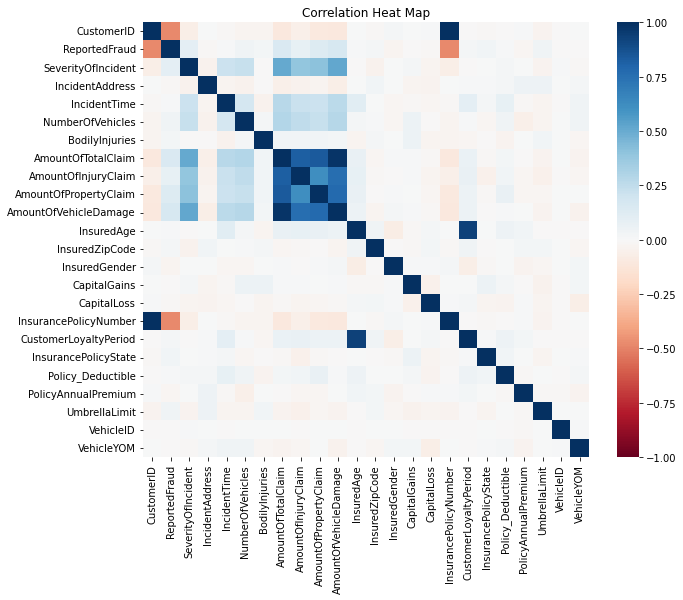

In [ ]:
# correlation heatmap
plt.figure(figsize=(10, 8))
plt.title('Correlation Heat Map')
sns.heatmap(df.corr(),cmap='RdBu', vmin=-1, vmax=1)

From the above heatmap, we can conclude that Customer Loyalty Period is positively correlated with Insured Age. Amount of total claim, Injury claim, property claim, vehicle damage are related with each other. Our target Reported Fraud have no obviously correlation with other features except CustomerID and Insurance Policy Number. Since we will not use CustomerID and Policy Number to predict Fraud, there is no multicollinearity issue.

In [ ]:
df.drop(columns=['CustomerID', 'InsurancePolicyNumber'],inplace=True)

#### Barplot

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Distribution of Reported Fraud')]

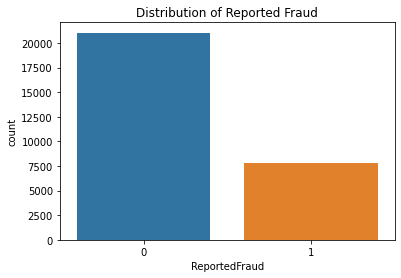

In [ ]:
# plot the distribution of Reported Fraud
sns.countplot(df['ReportedFraud']).set(title = 'Distribution of Reported Fraud')

Our targets are in highly imbalance. In the section Feature Engineering, we fix this problem with oversampling.

[Text(0.5, 1.0, 'Distribution of Type of Incidents')]

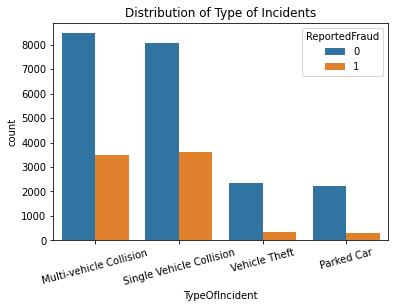

In [ ]:
# plot the distribution of Type Of Incidents
plt.xticks(rotation=15)
sns.countplot(x='TypeOfIncident',hue='ReportedFraud',data=df).set(title = 'Distribution of Type of Incidents')

More incidents are collision including multi-vehicle collision and single vehicle collision. The Reported Fraud rate of collision is higher than vehicle theft and parked car.

[Text(0.5, 1.0, 'Distribution of Authorities Contacted')]

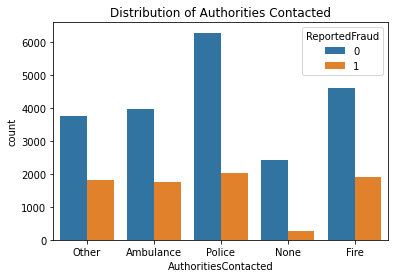

In [ ]:
# plot the distribution of Authorities Contacted
# plt.xticks(rotation=15)
sns.countplot(x='AuthoritiesContacted',hue='ReportedFraud',data=df).set(title = 'Distribution of Authorities Contacted')

Police are the most authorities that are contacted. The ReportedFraud are similar for known Authorities Contacted except for None.

[Text(0.5, 1.0, 'Distribution of Insured Education Level')]

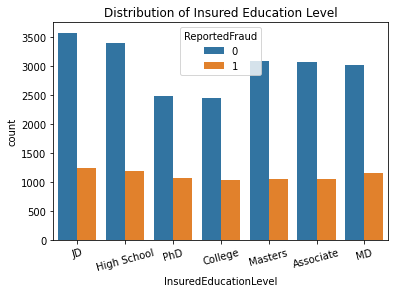

In [ ]:
# plot the distribution of Insured Education Level
plt.xticks(rotation=15)
sns.countplot(x='InsuredEducationLevel',hue='ReportedFraud',data=df).set(title = 'Distribution of Insured Education Level')

Though the numbers of each education level are different, the total reported fraud are similar among all education level. The overall trend are similar.

[Text(0.5, 1.0, 'Distribution of Insured Occupation')]

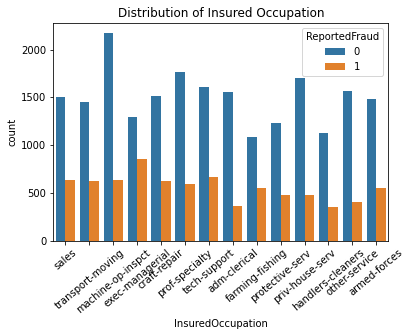

In [ ]:
# plot the distribution os Insured Occupation
plt.xticks(rotation=40)
sns.countplot(x='InsuredOccupation',hue='ReportedFraud',data=df).set(title = 'Distribution of Insured Occupation')

Machine-op-inspct has large total number but less Reported Fraud, we can reasonably guess that they have a sharper sense when selecting insurance because they know more about cars. Exec-managerial has the most Reported Fraud number but with less total number.

[Text(0.5, 1.0, 'Distribution of Insured Relationship')]

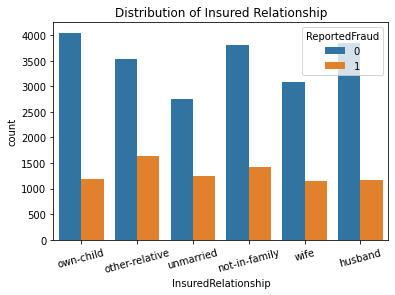

In [ ]:
# plot the distribution of Insured Relationship
plt.xticks(rotation=15)
sns.countplot(x='InsuredRelationship',hue='ReportedFraud',data=df).set(title = 'Distribution of Insured Relationship')

We can see from the graph that those unmarried have a larger percentage to report Fraud. While those own child have a lower rate to report Fraud.

#### Daily and weekly trend of reported fraud

In this part, we aggregate the data daily and weekly to track the trend of Report Fraud. By correlate with other trend, we can check whether some factors influence the Reported Fraud.

In [ ]:
# change string to datetime
from datetime import datetime
df['DateOfIncident'] = df['DateOfIncident'].apply(lambda x: pd.to_datetime(x))

In [ ]:
train_daily_groupby = df.groupby('DateOfIncident').sum().reset_index()
train_daily_groupby

,DateOfIncident,ReportedFraud,SeverityOfIncident,IncidentAddress,IncidentTime,NumberOfVehicles,BodilyInjuries,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,InsuredGender,CapitalGains,CapitalLoss,CustomerLoyaltyPeriod,InsurancePolicyState,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,VehicleID,VehicleYOM
0,2015-01-01,33,312,223017,1417,230,122,5575648,779306,837663,3958679,5382,69315967,63.0,3428500,-3447800,27074,271,150416,166598.59,88289673,2776402,279010
1,2015-01-02,89,718,468225,3364,491,277,12415966,1800426,1624808,8990732,11273,149506790,118.0,6406200,-6894400,58059,627,320091,343900.05,138729906,5961346,586003
2,2015-01-03,99,944,566385,4113,587,383,18642314,2611026,2486746,13616678,14496,182424410,164.0,8400200,-7845200,79934,712,430294,443459.76,299371412,7375562,723910
3,2015-01-04,69,839,522593,3808,568,338,16910343,2423591,2436181,12050571,13969,170125022,185.0,7749900,-6868100,79064,688,392015,426342.77,268206123,7002998,679804
4,2015-01-05,93,984,566345,4257,626,373,19583778,2757789,2908446,13996622,14752,184914003,170.0,10440600,-7748300,80657,767,459917,450291.90,343192138,7298081,737821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2015-03-09,0,6,2809,18,7,2,88673,10197,8104,70372,100,879003,1.0,124000,-123300,657,6,1748,2072.09,0,51116,3997
68,2015-03-10,1,4,1746,22,3,2,63019,10760,5380,46879,37,474771,1.0,0,-60300,186,3,1505,1231.37,0,39280,1999
69,2015-03-11,1,9,4428,51,7,4,169136,24704,20305,124127,113,1425336,3.0,103100,-57000,570,6,4835,3856.85,0,55029,6012
70,2015-03-12,1,4,1563,22,3,2,61476,10572,5286,45618,36,477373,1.0,0,0,186,3,1372,1234.81,0,12125,1999


<ipython-input-41-3f4d1397193a>:6: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  ax.figure.legend(loc='best')


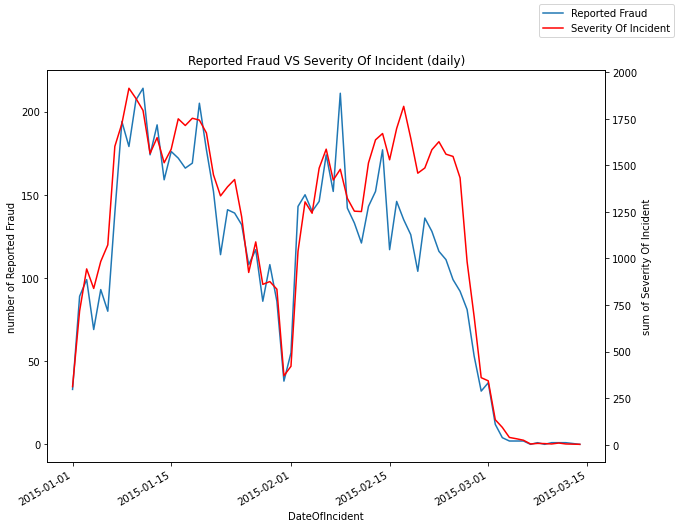

In [ ]:
# daily trend of Reported Fraud
plt.rcParams["figure.figsize"] = (10,8)
ax = train_daily_groupby.plot(x="DateOfIncident", y="ReportedFraud", label='Reported Fraud', legend=False)
ax2 = ax.twinx()
train_daily_groupby.plot(x="DateOfIncident", y="SeverityOfIncident", ax=ax2, label='Severity Of Incident', legend=False, color="r")
ax.figure.legend(loc='best')
ax.set_ylabel('number of Reported Fraud')
ax2.set_ylabel('sum of Severity Of Incident')
plt.title('Reported Fraud VS Severity Of Incident (daily)')
plt.show()

The trend of Reported Fraud and the trend of Severity Of Incident are correlated with each other. We will then check the correlation among all the trends.

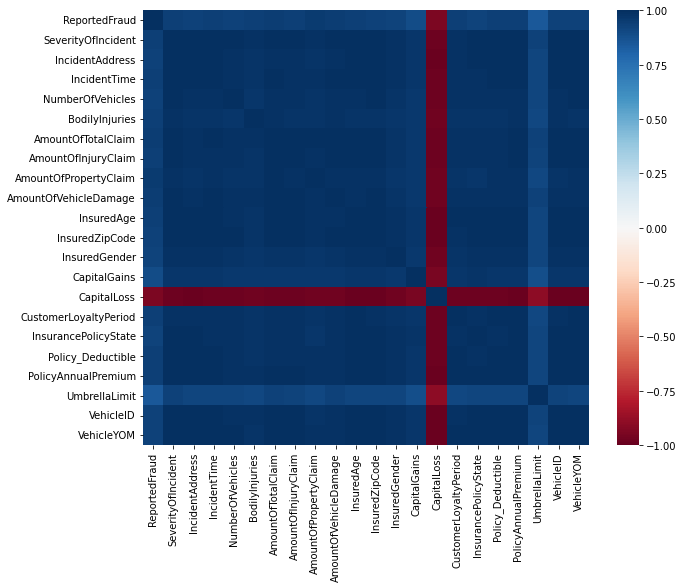

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_daily_groupby.corr(),cmap='RdBu', vmin=-1, vmax=1)

The heatmap are covered with dark red and dark blue, which indicates the trend are of high similarities. In other words, we can use those features to detect the insurance fraud.

We continue to check the weekly trend.

In [ ]:
# Do the similar thing above but change daily into weekly
train_weekly_groupby = df.groupby([pd.Grouper(key='DateOfIncident', freq='W-MON')]).sum().reset_index()
train_weekly_groupby

,DateOfIncident,ReportedFraud,SeverityOfIncident,IncidentAddress,IncidentTime,NumberOfVehicles,BodilyInjuries,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,InsuredGender,CapitalGains,CapitalLoss,CustomerLoyaltyPeriod,InsurancePolicyState,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,VehicleID,VehicleYOM
0,2015-01-05,383,3797,2346565,16959,2502,1493,73128049,10372138,10293844,52613282,59872,756286192,700.0,36425400,-32803800,324788,3065,1752733,1830593.07,1137789252,30414389,3006548
1,2015-01-12,1187,11531,6246631,50157,7365,4246,228217528,31323729,32919924,164589894,161659,2050239146,2258.0,97733700,-100306600,874258,8219,4719222,5134052.21,5002284067,84422412,8178185
2,2015-01-19,1239,11710,6706176,51384,7793,4083,222395358,31562854,31204534,160089633,167131,2145498906,2358.0,98884700,-112332700,890884,8756,4910126,5423996.09,4035459952,88367381,8525917
3,2015-01-26,963,9417,5501314,39411,5974,3681,183567385,25953977,27608511,130211820,132797,1753070810,1893.0,77410400,-91024300,681462,6743,3717664,4399780.26,2836536003,72036557,6967012
4,2015-02-02,633,5491,3168191,24213,3910,1727,102858208,14381092,14856377,73896643,79937,1017029698,1156.0,45393700,-53404700,423989,3826,2294150,2541183.25,1954460951,41375745,4076731
5,2015-02-09,1115,9842,5441680,41372,6459,3705,185981758,26273294,25300539,134469335,137236,1795126102,1949.0,78491900,-90060400,703996,7088,3994667,4525046.43,3243112337,74453180,7215050
6,2015-02-16,989,10555,5713718,44518,7258,3626,203019548,27229063,27326445,148717008,145266,1889002130,2017.0,88282800,-90321700,747427,7581,4082482,4648920.89,3769491428,77425392,7529274
7,2015-02-23,856,11178,6292330,45981,7558,3890,206255403,30474310,26810636,149449498,154975,2035664568,2196.0,88023600,-100251100,797271,8321,4420323,5125329.21,4413444240,84348938,8125729
8,2015-03-02,406,5487,3154203,23722,3528,1893,95960540,13363862,13097989,69596647,77311,1009980713,1063.0,52328000,-47128200,395521,4348,2152253,2481847.97,1957655889,41188143,4036284
9,2015-03-09,11,205,106373,883,212,73,4038080,586102,583655,2868323,2866,33527574,48.0,2070300,-1436700,14889,142,78629,86086.98,14817322,1341480,146117


<ipython-input-45-118bf6d10820>:6: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  ax.figure.legend(loc='best')


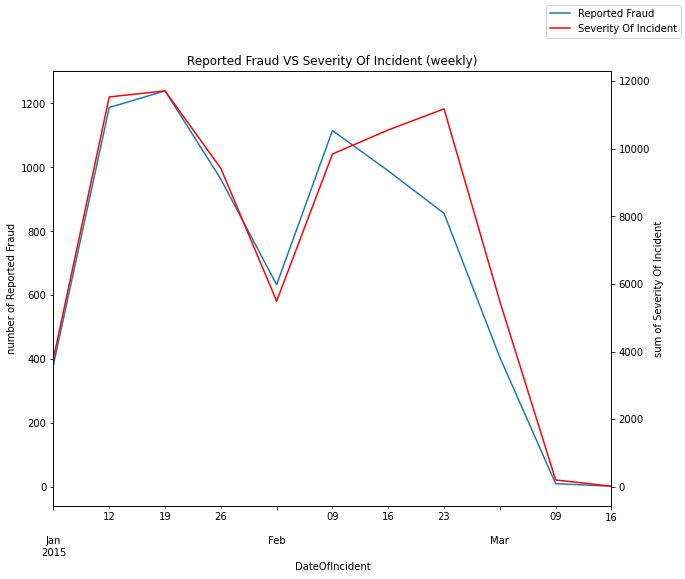

In [ ]:
# weekly trend of Reported Fraud
plt.rcParams["figure.figsize"] = (10,8)
ax = train_weekly_groupby.plot(x="DateOfIncident", y="ReportedFraud", label='Reported Fraud', legend=False)
ax2 = ax.twinx()
train_weekly_groupby.plot(x="DateOfIncident", y="SeverityOfIncident", ax=ax2, label='Severity Of Incident', legend=False, color="r")
ax.figure.legend(loc='best')
ax.set_ylabel('number of Reported Fraud')
ax2.set_ylabel('sum of Severity Of Incident')
plt.title('Reported Fraud VS Severity Of Incident (weekly)')
plt.show()

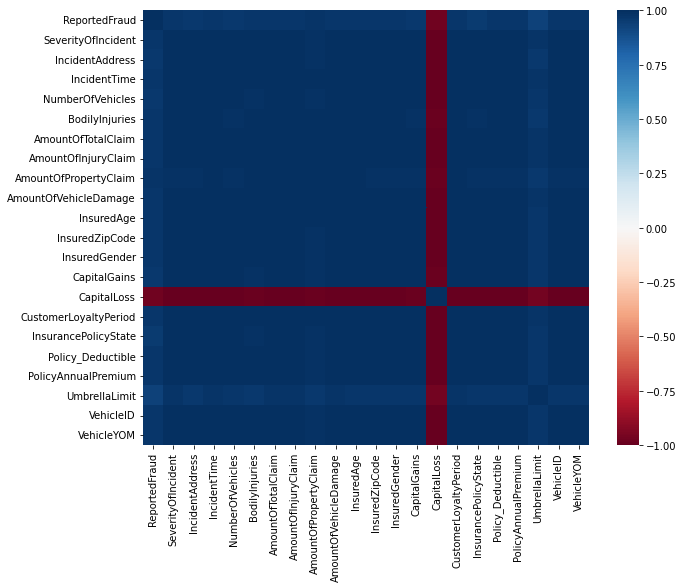

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_weekly_groupby.corr(),cmap='RdBu', vmin=-1, vmax=1)

We have similar results with daily trends analysis.

### Feature Engineering

This is the last step before we fit a model. Now we have a nice dataframe df for all the information, we want to divide them into parts that can be feed directly into the models. First, We split our data feature and label columns. After that, we continue to split them into into train and test sets. We also want to seperate the numerical columns and the categorical columns, because we want to utilize one hot encoding on the latter. 

#### Data grouping

In [ ]:
# Split into Features and Label
X = df.drop(['ReportedFraud'],axis=1)
y = df['ReportedFraud']

In [ ]:
# Form train and test dataframes with percentage 30% and 70%
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30, random_state = 100)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20185, 37)
(8651, 37)
(20185,)
(8651,)


In [ ]:
# Group categorical columns
cat_cols = ['TypeOfIncident', 'AuthoritiesContacted', 'InsuredEducationLevel', 'InsuredOccupation', 
            'Policy_CombinedSingleLimit', 'InsuredRelationship', 'VehicleMake']

In [ ]:
# Group numerical columns
num_cols = ['DateOfIncident', 'InsuredGender', 'InsurancePolicyState','IncidentTime', 'NumberOfVehicles', 
            'BodilyInjuries', 'IncidentAddress','AmountOfInjuryClaim', 'AmountOfPropertyClaim', 'Witnesses',
            'AmountOfVehicleDamage', 'InsuredAge', 'AmountOfTotalClaim', 'SeverityOfIncident',
            'InsuredZipCode','CapitalGains', 'CapitalLoss', 'CustomerLoyaltyPeriod',
            'DateOfPolicyCoverage','Policy_Deductible', 'PolicyAnnualPremium', 'UmbrellaLimit', 'VehicleID',
            'IncidentState', 'IncidentCity', 'VehicleYOM']

In [ ]:
df_cat_train = X_train[cat_cols]
df_cat_test = X_test[cat_cols]
print(df_cat_train.shape)
print(df_cat_test.shape)

df_num_train = X_train[num_cols]
df_num_test = X_test[num_cols]
print(df_num_train.shape)
print(df_num_test.shape)

(20185, 7)
(8651, 7)
(20185, 26)
(8651, 26)


In [ ]:
df_cat_train

,TypeOfIncident,AuthoritiesContacted,InsuredEducationLevel,InsuredOccupation,Policy_CombinedSingleLimit,InsuredRelationship,VehicleMake
5161,Multi-vehicle Collision,Ambulance,JD,machine-op-inspct,100/300,not-in-family,Mercedes
4330,Parked Car,Police,PhD,exec-managerial,500/1000,not-in-family,Toyota
14155,Multi-vehicle Collision,Fire,Associate,exec-managerial,250/500,husband,Accura
12691,Multi-vehicle Collision,Fire,Associate,exec-managerial,100/300,other-relative,Nissan
12725,Parked Car,None,High School,other-service,500/1000,husband,Honda
...,...,...,...,...,...,...,...
12119,Parked Car,Police,Associate,armed-forces,250/500,unmarried,Saab
24423,Multi-vehicle Collision,Fire,JD,prof-specialty,500/1000,other-relative,Suburu
14147,Multi-vehicle Collision,Ambulance,High School,prof-specialty,100/300,husband,Saab
23320,Single Vehicle Collision,Ambulance,Associate,prof-specialty,500/1000,not-in-family,Nissan


#### OneHotEncoder

One hot encoding creates a binary representation of the categorical data, where each category is represented by a binary vector with a length equal to the number of possible categories.

In [ ]:
# We use OneHotEncoder to process categorical columns
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(df_cat_train)

df_cat_train_ohe = ohe.transform(df_cat_train).toarray()
df_cat_test_ohe = ohe.transform(df_cat_test).toarray()

In [ ]:
print(df_cat_train_ohe.shape)
print(df_cat_test_ohe.shape)

(20185, 60)
(8651, 60)


#### Standard scaler

Standard scaling is used to transform numeric data by subtracting the mean of the data and dividing by the standard deviation, so that the transformed data has a mean of 0 and a standard deviation of 1. This is useful because many machine learning algorithms use the assumption that the data is normally distributed with a mean of 0 and a standard deviation of 1, and applying standard scaling can help to ensure that the data meets this assumption.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_cat_train_ohe)

df_num_train_ss = scaler.transform(df_cat_train_ohe)
df_num_test_ss = scaler.transform(df_cat_test_ohe)

In [ ]:
X_train_con = np.concatenate([df_cat_train_ohe, df_num_train_ss], axis=1)
X_test_con = np.concatenate([df_cat_test_ohe, df_num_test_ss], axis=1)

#### Fix imbalanced data

When analyzing data, we realized the unbalanced distribution of reported frauds and normal incidents. Hence, we conduct random sampling to keep the proportions the same. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Distribution of Reported Fraud in y_train')]

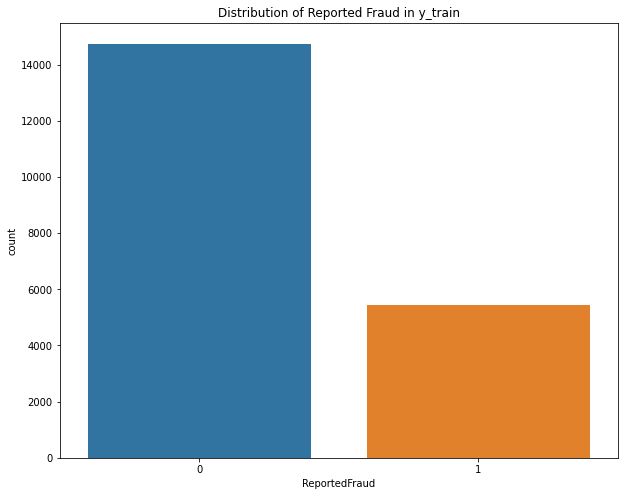

In [ ]:
sns.countplot(y_train).set(title = 'Distribution of Reported Fraud in y_train')

In [ ]:
percentage = sum(y_train)/len(y_train)
print('data reported fraud count for',percentage,'%')

data reported fraud count for 0.2694079762199653 %


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_con, y_train)

In [ ]:
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 14747), (1, 14747)]


This is the end of Data processing section. We now have clean and balanced dataset, which can be feed into our models.

# Model Construuction


## Logistic Regression

In this part, we first use Logistic Regreesion to fit the model. Logistic Regression is a classical classification model, which is easy to implement and highly efficient. Although it may not be that accurate, we want to use the model as a baseline, and compare it with other models built in the following parts. 

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_resampled,y_resampled)

LogisticRegression()

In [ ]:
lr_train_preds_score = lr.score(X_resampled,y_resampled)
lr_train_preds_score

0.6229063538346783

In [ ]:
lr_test_preds_score = lr.score(X_test_con,y_test)
lr_test_preds_score

0.5934574037683504

The training accuuracy is 62.29%, and the testing accuracy is 59.34%. The accuracy is fair as we supposed. 

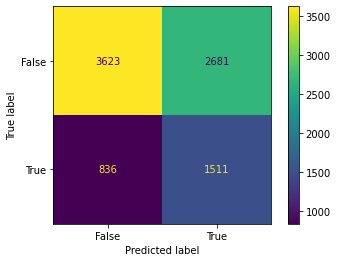

In [ ]:
from sklearn import metrics
lr_test_preds = lr.predict(X_test_con)
cm = metrics.confusion_matrix(y_test, lr_test_preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

We plot the confusion matrix here. The confussion matrix can help us identify whether the model can classify both the true labels and false labels correctly. That is, we do not want the model to be abble to classify the true labels but not the false labels. It is specially important for the imblanced dataset like what we use here. 

From the confusion matrix plotted here, the model does not show the difference between identifying the true labels and the false labels. 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


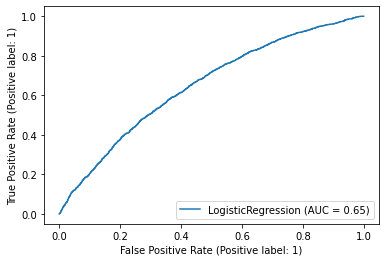

In [ ]:
metrics.plot_roc_curve(lr, X_test_con, y_test)

The ROC-AUC curve is plotted above. The x-axis is false positive rate, and the y-axis is true positive rate. The model can classify both the true labels and false labels, although the accuracy is not that high.

## Decision Tree Classifier

We use the decision tree classifier as the second model. Decision tree is easy to implement and explain. The method is also intuitive. The disadvantage of this model is that it may not be robust enough to handle the small changes in some data.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
para = {'criterion': ('entropy', 'gini'), 'max_depth': [50, 100]}
clf = GridSearchCV(dtc, para)
clf.fit(X_resampled, y_resampled)
clf.best_params_

{'criterion': 'gini', 'max_depth': 50}

In [ ]:
dtc = DecisionTreeClassifier(criterion = 'gini', max_depth = 100)
dtc.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_depth=100)

In [ ]:
dtc_train_preds_score = dtc.score(X_resampled,y_resampled)
dtc_train_preds_score

0.9728080287516105

In [ ]:
dtc_test_preds_score = dtc.score(X_test_con,y_test)
dtc_test_preds_score

0.78869494856086

The training accuracy is 97.28%, and the testing accuracy is 78.87%. Decision tree has overfitted here. 

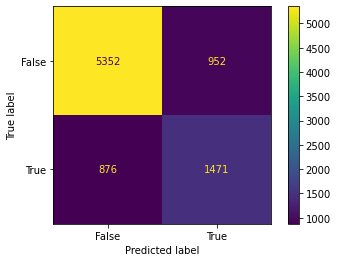

In [ ]:
from sklearn import metrics
dtc_test_preds = dtc.predict(X_test_con)
cm = metrics.confusion_matrix(y_test, dtc_test_preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

According to the confusion matrix here, the model performs better in predicting the false labels correctly. It is also shown in the ROC-AUC curve plotted below. 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


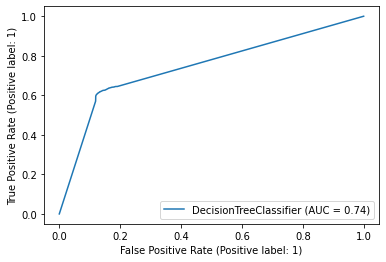

In [ ]:
metrics.plot_roc_curve(dtc, X_test_con, y_test)

## Random Forest Classifier

Random Forest Classifier is tried here. It is a collection of decision trees. With many decision trees, the robustness can be guaranteed for random forest. It is also easy to explain and intuitive as the decision tree. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_resampled,y_resampled)

RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
para = {'max_depth': [50, 100], 'n_estimators': [60, 80, 100, 120]}
clf = GridSearchCV(rfc, para)
clf.fit(X_resampled, y_resampled)
clf.best_params_

{'max_depth': 50, 'n_estimators': 120}

In [ ]:
rfc = RandomForestClassifier(n_estimators = 120, max_depth = 50)
rfc.fit(X_resampled,y_resampled)

RandomForestClassifier(max_depth=50, n_estimators=120)

In [ ]:
rfc_train_preds_score = rfc.score(X_resampled,y_resampled)
rfc_train_preds_score

0.9728080287516105

In [ ]:
rfc_test_preds_score = rfc.score(X_test_con,y_test)
rfc_test_preds_score

0.8394405271066928

The training accuracy is 97.28%, and the testing accuracy is 83.94%. The testing accuracy has been highly improved compared with the decision tree classifier. The model may have overfitted here. We have tuned the parameters, and we use 120 trees to construct the random forest models. This may be the reason why the model has overfitted.

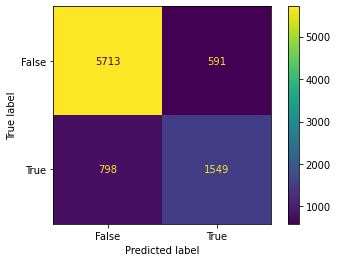

In [ ]:
from sklearn import metrics
rfc_test_preds = rfc.predict(X_test_con)
cm = metrics.confusion_matrix(y_test, rfc_test_preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

The random forest classifier shows equally great performance in identifying the true labels and false labels. The same result can be concluded from the ROC-AUC curve plotted below. The overall performance of the random forest classifier is great. 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


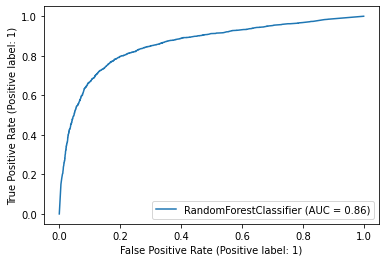

In [ ]:
metrics.plot_roc_curve(rfc, X_test_con, y_test)

## AdaBoost Classifier

AdaBoost is a series of decision trees. During the training process, it uses the boosting and the additive models. That is, it will build a series of decision trees with more weights puting into instances that are difficult to classify. We hope this model can help us identify successfully all the samples, especially for the samples that are difficult to classify.  

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adc = AdaBoostClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
para = {'n_estimators': [80, 100, 120]}
clf = GridSearchCV(rfc, para)
clf.fit(X_resampled, y_resampled)
clf.best_params_

{'n_estimators': 120}

In [ ]:
adc = AdaBoostClassifier(n_estimators = 100)
adc.fit(X_resampled,y_resampled)

AdaBoostClassifier(n_estimators=100)

In [ ]:
adc_train_preds_score = adc.score(X_resampled,y_resampled)
adc_train_preds_score

0.6224316810198685

In [ ]:
adc_test_preds_score = adc.score(X_test_con,y_test)
adc_test_preds_score

0.590567564443417

The training accuracy is 62.24%, and the testing accuracy is 59.06%. It is surprising that the AdaBoost does not show a great performance. We can see the confusion matrix below to dive into the possible reasons. It seems that AdaBoost cannot identify the false labels correctly. It may be related to the feature of AdaBoost. That is, the model may pay too much attention on classifying the true labels correctly.

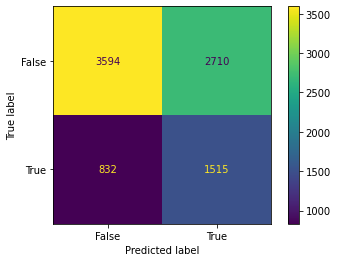

In [ ]:
from sklearn import metrics
adc_test_preds = adc.predict(X_test_con)
cm = metrics.confusion_matrix(y_test, adc_test_preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


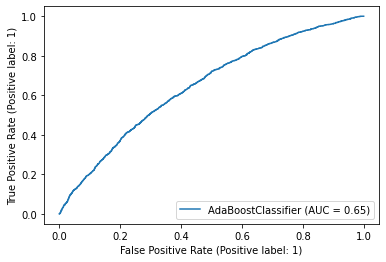

In [ ]:
metrics.plot_roc_curve(adc, X_test_con, y_test)

## Neural Networks

Neural Networks are popular models nowadays. Here, we also implement a simple version by sklearn, that is the multi-layer perceptron classifier. The solver for weight optimization is in the family of quasi-Newton methods, and the L2 regularization term is 1e-5. We want to compare the perfomance of different models, so we do not intend to use complex structure of layers here.

In [ ]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver = 'lbfgs', alpha = 1e-5, hidden_layer_sizes=(16, 64, 32))
nn.fit(X_resampled,y_resampled)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(16, 64, 32), solver='lbfgs')

In [ ]:
nn_train_preds_score = nn.score(X_resampled,y_resampled)
nn_train_preds_score

0.8565470943242693

In [ ]:
nn_test_preds_score = nn.score(X_test_con,y_test)
nn_test_preds_score

0.759912148884522

The training accuracy is 85.65%, and the testing accuracy is 75.99%. 

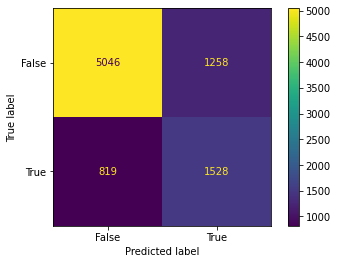

In [ ]:
from sklearn import metrics
nn_test_preds = nn.predict(X_test_con)
cm = metrics.confusion_matrix(y_test, nn_test_preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

Neural Networks show the similar ability to classify the true labels and false labels in this project. 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


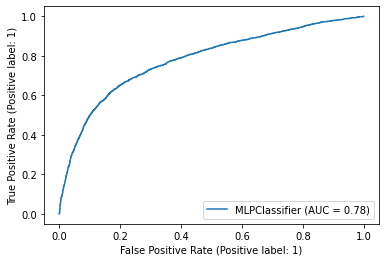

In [ ]:
metrics.plot_roc_curve(nn, X_test_con, y_test)

# Model Comparision and Conclusion

After sucessfully constructing 5 different models to fit our data, we want to compare the performance of each model and choose a best one in terms of test accuracy.

In [ ]:
models=['Logistic Regression', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Neural Networks']
scores=[lr_test_preds_score, dtc_test_preds_score, rfc_test_preds_score, adc_test_preds_score, nn_test_preds_score]

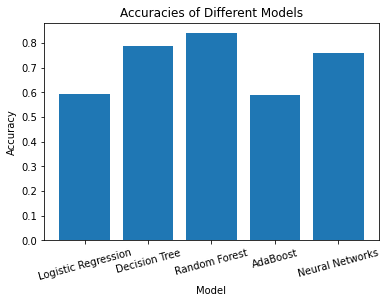

In [ ]:
plt.bar(models, scores, width=0.8, bottom=None, align='center')
plt.title('Accuracies of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.show()

We can tell from the plot that the Random Forest model has the highest accuracy among all 5 models.

To conclude with all the information we presented above, we successfully build a random forest predictive model that has achieved training accuracy of 97.28% and test accuracy of 83.94%. Althoguh we still have room to grow, this accruacy is satisfying and can contribute in fraud detection, helping insurance company recognize potential fraud in the early steps and they can continue to look at each potential fraud more carefully and detailedly if they wish.  

# Obstacles & Challenges

Challenge: There are some missing values and missing data we need to handle before modeling.

Solution: After checking the null value percentage, we conclude that the missing value only counts for a small amount of rows. Instead of data imputation, we directely drop nans.


Challenge: The dataset is highly unbalanced because there is less fraud than normal claims. 

Solution: The ratio of fraud and non-fraud data is 1:4 that is hignly unbalanced. We upsampled the reported fraud data into the same amount (14747) as reported not fraud.


# Potential Next Steps

The sparse data generated by one-hot encoding may have influenced the model performance negatively. There are 7 categorical features in the original dataset, and we transform them into 34 variables. 60 input variables may be too many for the models to show great performance. The possible solution can be that we can investigate into these features, and try to only fit the models with the important features instead of the unrelated features.

One potential positive additive to the project is that we can try downsampling to handle the imbalanced dataset. In this project, we have used the method of upsampling. The models may show different perfomances with downsampling. Then, we may choose the model with best performance.

Another possible step is that we can explore more different kinds of model to fit to our data. For example, we could fit k neighbor classification model or other types of neural networks. If the model achieves higher accuracy, this could alter our choice of model and improve performance of our project. 